<a href="https://colab.research.google.com/github/priyanshu0627/Siamese_network/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

In [ ]:
base_dir = '/content/drive/MyDrive/minor_2/new data set/data/train'
train_test_split = 0.7
no_of_files_in_each_class = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

12 categories found in the dataset


In [ ]:
name_list = []
x = []
y = []
y_label = 0

In [ ]:
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    name_list.append(temp)
name_list 

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
 [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]]

In [ ]:
name_list = np.asarray(name_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, name_list.shape)

X, Y shape (120, 100, 100, 3) (120,) (12, 10)


In [ ]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

8 classes for training and 4  classes for testing


In [ ]:
train_files = train_size * no_of_files_in_each_class
train_files

80

In [ ]:
x_train = x[:train_files]
y_train = y[:train_files]
name_train = name_list[:train_size]
name_train

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]])

In [ ]:
x_val = x[train_files:]
y_val = y[train_files:]
name_test = name_list[train_size:]
name_test

array([[ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
       [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]])

In [ ]:
print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, name_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, name_test.shape)

X&Y shape of training data : (80, 100, 100, 3) and (80,) (8, 10)
X&Y shape of testing data : (40, 100, 100, 3) and (40,) (4, 10)


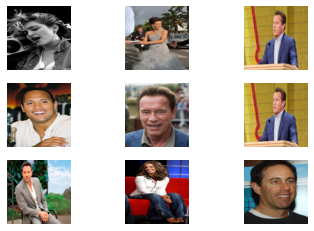

In [ ]:
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)])
plt.show()

In [ ]:
def get_batch(batch_size, call_type):
    
    temp_x = None
    temp_name_list = None
    start=None
    end=None
    batch_x=[]
    
    if call_type == 'train':
        temp_x = x_train
        temp_name_list = name_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_name_list = name_test
        start = train_size+1
        end = len(folder_list)-1
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_name_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_name_list[class_list[i]])]

        else:
            temp_list = np.append(temp_name_list[:class_list[i]].flatten(), temp_name_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

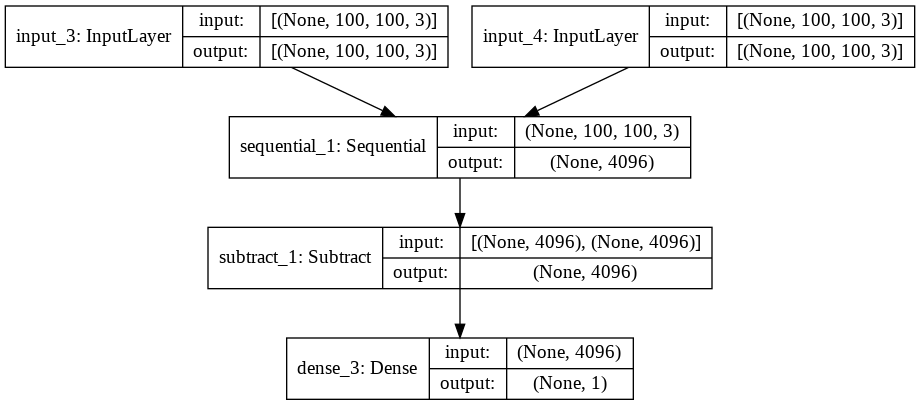

In [ ]:
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)

input=[left_input, right_input]
output=prediction

siamese_net = Model(input, output)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 39, 128)       401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 256)        

In [ ]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_name_list = name_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list), n_val)

    for i in class_list:  
        j = np.random.choice(name_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                temp[1][k] = x[np.random.choice(name_list[i])]
            else:
                temp[1][k] = x[np.random.choice(np.append(name_list[:i].flatten(), name_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

In [ ]:
nway_one_shot(model, 5, 7)

2 correctly classified among 7


28.571428571428573

In [ ]:
epochs = 5000
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%50 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Streaming output truncated to the last 5000 lines.
Epoch: 393 , Loss: 0.7055704593658447
Epoch: 394 , Loss: 0.705542266368866
Epoch: 395 , Loss: 0.70546555519104
Epoch: 396 , Loss: 0.7055174708366394
Epoch: 397 , Loss: 0.7054463028907776
Epoch: 398 , Loss: 0.7053606510162354
Epoch: 399 , Loss: 0.705327033996582
Epoch: 400 , Loss: 0.7053266167640686
10 correctly classified among 100
Accuracy as of 400 epochs: 10.0
Epoch: 401 , Loss: 0.705200731754303
Epoch: 402 , Loss: 0.7051714658737183
Epoch: 403 , Loss: 0.7051409482955933
Epoch: 404 , Loss: 0.7050879001617432
Epoch: 405 , Loss: 0.7050364017486572
Epoch: 406 , Loss: 0.7049992084503174
Epoch: 407 , Loss: 0.7049437165260315
Epoch: 408 , Loss: 0.7049107551574707
Epoch: 409 , Loss: 0.7048205733299255
Epoch: 410 , Loss: 0.7047680616378784
Epoch: 411 , Loss: 0.7047612071037292
Epoch: 412 , Loss: 0.7047421932220459
Epoch: 413 , Loss: 0.7045942544937134
Epoch: 414 , Loss: 0.7048395872116089
Epoch: 415 , Loss: 0.7043783068656921
Epoch: 416 , L

In [ ]:
cd /content/drive/MyDrive/minor_2

/content/drive/MyDrive/minor_2


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets
